## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [2]:
# pandas and numpy
import pandas as pd
import numpy as np
import multiprocessing

# punctuation, stop words, emojis, and English language model
from string import punctuation
import spacy
import emoji
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer, LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# word cloud
from wordcloud import WordCloud, ImageColorGenerator

In [40]:
# load data 
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(10000)
congress_tweets = congress_tweets.reset_index(drop=True)

congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.196520e+18,RepPeteOlson,2019-11-18T15:18:24-05:00,"“@RepPeteOlson, a Houston Republican, is the l...",Pete Olson,Rep,3-Jan-09,12/9/1962,M,TX,22,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
1,1.274760e+18,JohnCornyn,2020-06-21T13:28:23-04:00,https://twitter.com/photogdina/status/12747524...,John Cornyn,Sen,2-Dec-02,2/2/1952,M,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
2,1.189970e+18,SenJackyRosen,2019-10-31T14:16:52-04:00,It’s no secret I’m passionate about STEM educa...,Jacky Rosen,Sen,3-Jan-19,8/2/1957,F,NV,Senate,Democrat,"512,058","539,260","531,373","463,567"
3,1.234940e+18,SenatorLankford,2020-03-03T15:46:40-05:00,@CDCgov and medical researchers throughout the...,James Lankford,Sen,3-Jan-15,3/4/1968,M,OK,Senate,Republican,"949,136","420,375","443,547","891,325"
4,1.152350e+18,SenKamalaHarris,2019-07-19T18:53:00-04:00,Earlier this week we did something that's neve...,Kamala Harris,Sen,3-Jan-17,10/20/1964,F,CA,Senate,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [4]:
# remove punctuation, stop words, url links, and retweet/quote tweet flags
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation) | {'“', '–', '“ ', '\n\n', "'", "”", "”", "•", " "} # appending some more symbols I found during EDA
    
    emoji_free = emoji.replace_emoji(text, "")
    
    doc = nlp(emoji_free)
    
    spacy_words = [token.text for token in doc if token.text not in punc]  # remove punctuation after tokenization
    
    spacy_words = [word for word in spacy_words if not word.startswith(('http', 'RT', 'QT', 'rt', 'qt', 'de', 
                                                                        'amp', 'tn', 'nt', '@'))]
    
    text_clean = [word for word in spacy_words if word.lower() not in stop_words]  # match case
    
    return text_clean

In [5]:
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens'].head()

0    [win, women, reproductive, health, morning, SC...
1                            [Stay, safe, Congressman]
2    [disgusting, act, specter, lynching, alive, Se...
3    [Big, factory, farms, cause, harm, —, environm...
4    [regression, analyses, voter, suppression, fac...
Name: tokens, dtype: object

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1 - word cloud

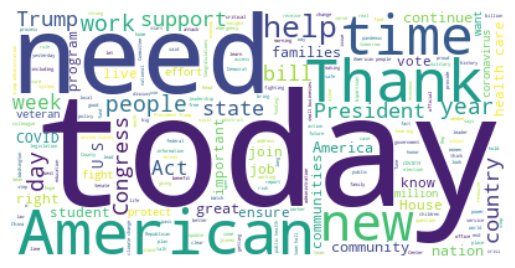

In [6]:
# word cloud
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))

wordcloud = WordCloud(background_color="white", random_state=42).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

### EDA 2 - topic modeling

In [7]:
# tf-idf matrix and fitting LDA
# ----------
# initialize tf-idf
tf = TfidfVectorizer(tokenizer = rem_punc_stop,
                     token_pattern = None)  

tfidf_mat = tf.fit_transform(congress_tweets['text'])

# initialize LDA model 
lda = LatentDirichletAllocation(n_components=5,   # adjust the # of components
                                max_iter=20,      # adjust the # of iterations to fit model
                                random_state=42)   # set seed for reproducibility

# fit LDA
lda = lda.fit(tfidf_mat)  # use the sparse matrix created above 

In [8]:
# function to get and view top words for each topic
# ---------- 
def print_top_words(model, feature_names, n_top_words):    # define function and set parameters
    for topic_idx, topic in enumerate(model.components_):  # iterate over each topic 
        print("\nTopic #{}:".format(topic_idx))            # print topic index
        print(" ".join([feature_names[i]                   # print topics
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [9]:
# get feature names from tf-idf matrices 
# ---------- 
tf_feature_names = tf.get_feature_names_out()

# print top words
print_top_words(lda,                # model 
                tf_feature_names,   # feature names 
                20)                 # number of top words


Topic #0:
lies bringbackourgirls 112 incompetence ethics juul diversity ruled chibokgirls hr5 momentum taylor thanksgiving privacy faster thought cool kent gains goodbye

Topic #1:
la el en y que para los por las con su hong se es al india kong un una este

Topic #2:
health 
 act need care people trump americans house bill help families today president workers american senate work time new

Topic #3:

 president today trump live join great tune watch town house hall congress discuss hearing national new time climate committee

Topic #4:
today thank 
 day work happy great community years time honor nation help president year country american women people support



The only topic that really makes sense is topic #1, but its theme is basically just "non-English words."

In [10]:
# calculate topic weights from distribution
# ----------
topic_dist_df = pd.DataFrame(lda.transform(tfidf_mat)) # distribution of topics for each tweet in the corpus 

# join back to dataframe and reset index
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())

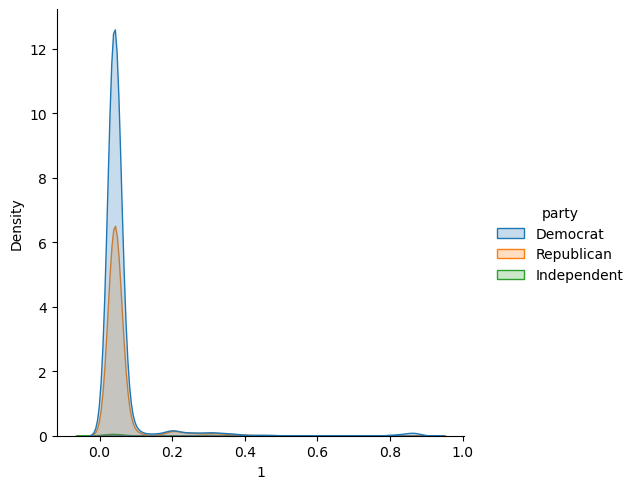

In [12]:
# histogram of topic 2
# ----------
sns.displot(df_w_topics,      # data
            x=df_w_topics[1], # x-axis feature subet to only topic 2
            hue = "party",  # by loan product
            kind = 'kde',     # specify kdensity plot
            fill = 'true')    # fill
plt.show()

### EDA 3 - ngrams

In [13]:
# initialize the Bag-of-Words CounterVectorizer
# ----------

countvec = CountVectorizer(stop_words=list(STOP_WORDS), # specify a list of stop words to extract 
                           ngram_range=(2,3))           # specify bi- and trigrams 

# turn tokenized words back into single strings
congress_tweets['tokens_str'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))

# fit and transform on tokens
ngrams = countvec.fit_transform(congress_tweets['tokens_str'])         

# create a dataframe out of ngram sparse matrix - need to densify bc DataFrame can't handle sparse matrix
dictionary_dataframe = pd.DataFrame(ngrams.todense(), # specify data to convert to dataframe 
                                    columns = countvec.get_feature_names_out()) # get features

# create dataframe of n-grams and their frequency, sort by descending
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'}).sort_values(by = ['freq'],
                                ascending = False).reset_index(drop = True)

# view just a subset
top_25_ngrams = dictionary_dataframe.loc[:,df_ngram[0:25]['ngrams']]
top_25_ngrams.head()

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


,covid 19,health care,president trump,american people,small businesses,trump administration,united states,public health,climate change,national security,...,house passed,house democrats,look forward,supreme court,pre existing,law enforcement,men women,mental health,watch live,trump admin
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


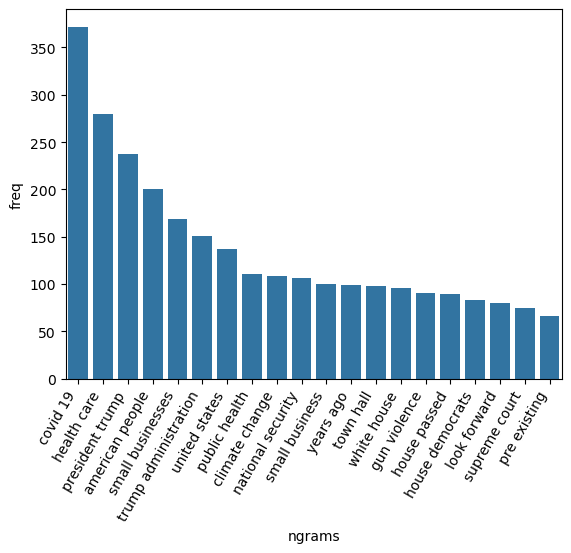

In [14]:
# bar plot
# ----------
sns.barplot(x="ngrams", 
            y = 'freq', 
            data=df_ngram[0:20])
plt.xticks(rotation=60, ha = "right")
plt.show()

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

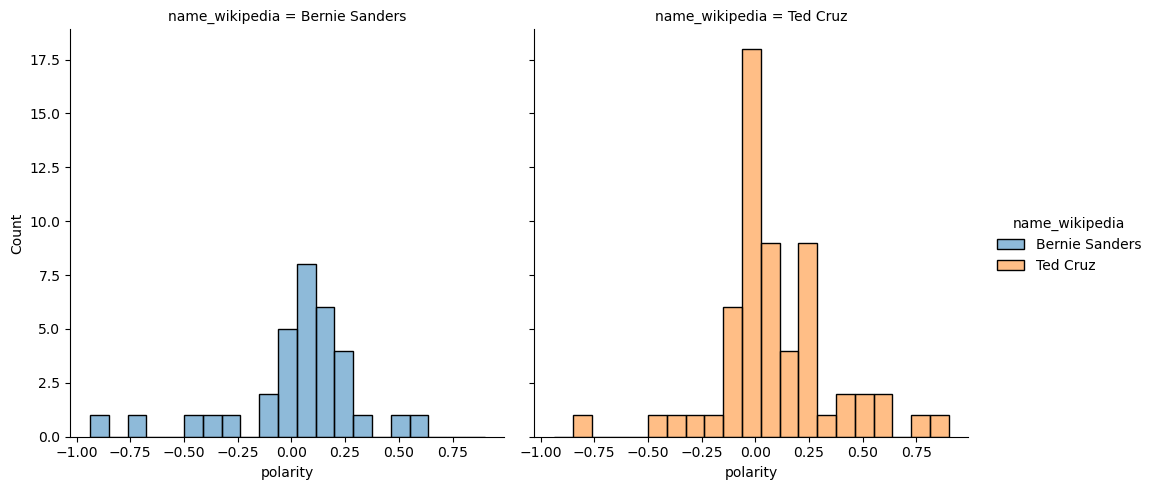

In [15]:
# create new column features of subjectivity and polarity
congress_tweets['subjectivity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.subjectivity)
congress_tweets['polarity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.polarity)

# filter to Bernie and Ted
filtered_tweets = congress_tweets[(congress_tweets['name_wikipedia'] == 'Bernie Sanders') | 
                                  (congress_tweets['name_wikipedia'] == 'Ted Cruz')]

# histogram of polarity 
sns.displot(filtered_tweets,            # specify data
            x="polarity",    # specify x-axix feature 
            hue = "name_wikipedia", # color by loan product
            col = "name_wikipedia") # color by loan product
plt.show()

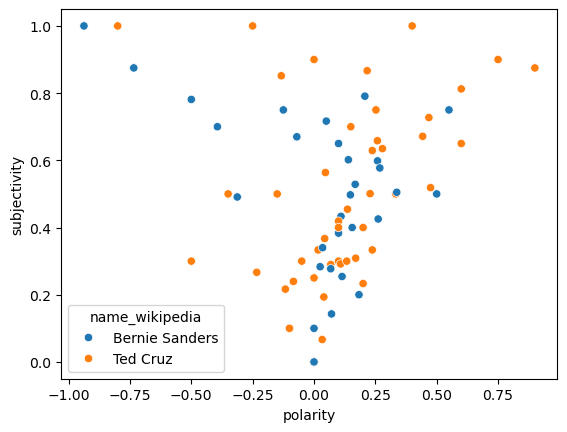

In [16]:
# scatter plot
sns.scatterplot(filtered_tweets, x="polarity", y = "subjectivity", hue="name_wikipedia")

plt.show()

I don't really see any clear pattern here that would indicate different sentiments.

#### Democrats v. Republicans word cloud

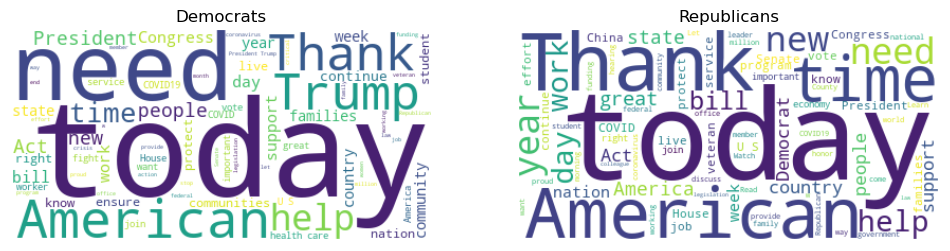

In [17]:
# word cloud

#separate by party
d_tweets = congress_tweets[congress_tweets['party'] == 'Democrat']
r_tweets = congress_tweets[congress_tweets['party'] == 'Republican']

d_text = ' '.join(d_tweets['tokens'].map(lambda text: ' '.join(text)))
r_text = ' '.join(r_tweets['tokens'].map(lambda text: ' '.join(text)))

d_wordcloud = WordCloud(background_color="white", random_state=42).generate(d_text)
r_wordcloud = WordCloud(background_color="white", random_state=42).generate(r_text)

# side-by-side of parties
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(d_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Democrats')

plt.subplot(1, 2, 2) 
plt.imshow(r_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Republicans')

plt.show()

#### Senators v. Representatives word cloud

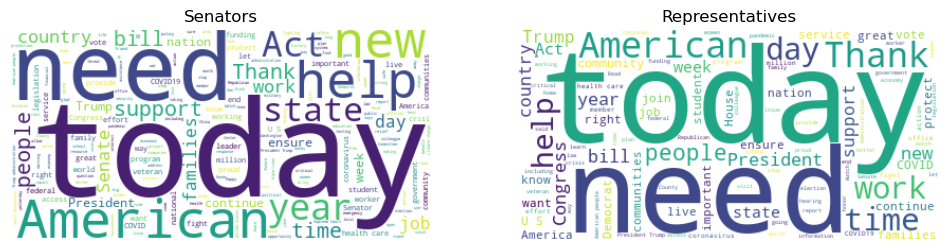

In [18]:
sen_tweets = congress_tweets[congress_tweets['position'] == 'Sen']
rep_tweets = congress_tweets[congress_tweets['position'] == 'Rep']

sen_text = ' '.join(sen_tweets['tokens'].map(lambda text: ' '.join(text)))
rep_text = ' '.join(rep_tweets['tokens'].map(lambda text: ' '.join(text)))

sen_wordcloud = WordCloud(background_color="white", random_state=42).generate(sen_text)
rep_wordcloud = WordCloud(background_color="white", random_state=42).generate(rep_text)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(sen_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Senators')

plt.subplot(1, 2, 2) 
plt.imshow(rep_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Representatives')

plt.show()

I don't really see any major differences here either. I feel like the word "today" is overly abundant everywhere.

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [19]:
# Engineered Features

# Adding a word count feature
congress_tweets['word_count'] = congress_tweets['tokens'].apply(lambda x: len(str(x).split()))

# rename topic labels for clarity
df_w_topics.rename({0: 'topic_0', 1: 'topic_1', 2: 'topic_2', 3: 'topic_3', 4: 'topic_4'}, axis=1, inplace=True)

# subset and join feature dfs
engineered_features = congress_tweets[["position", "party", "subjectivity", "polarity", "word_count"]].join(df_w_topics[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4']]).join(top_25_ngrams)

engineered_features = pd.get_dummies(engineered_features, columns = ["position", "party"], dtype = int)
engineered_features.head()

,subjectivity,polarity,word_count,topic_0,topic_1,topic_2,topic_3,topic_4,covid 19,health care,...,law enforcement,men women,mental health,watch live,trump admin,position_Rep,position_Sen,party_Democrat,party_Independent,party_Republican
0,0.645238,0.361905,43,0.028242,0.028034,0.820766,0.028959,0.093999,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0.500000,0.500000,3,0.073465,0.073465,0.075413,0.074758,0.702899,0,0,...,0,0,0,0,0,1,0,1,0,0
2,0.563889,-0.075000,36,0.031423,0.031371,0.033857,0.034050,0.869298,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0.333333,0.083333,20,0.037443,0.037443,0.849012,0.038042,0.038060,0,0,...,0,0,0,0,0,0,1,1,0,0
4,0.000000,0.000000,19,0.040257,0.040301,0.041083,0.040882,0.837477,0,0,...,0,0,0,0,0,1,0,1,0,0


### Tf-idf

In [20]:
# Frequency Based featurization
# ----------

# convert tf-idf matrix to an arrray and then to a dataframe
tfidf_df = pd.DataFrame(data = tfidf_mat.toarray(),       # convert to array than to dataframe
                         columns=tf.get_feature_names_out()) # specify column names as feature names from TF vectorizer

# sort by term frequency on the first document
tfidf_df.T.nlargest(10,  # transpose the matrix - columns become documents and rows are words
                     0)  # on column index 0 to show the largest


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
abortion,0.282457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
court,0.234875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
invalidating,0.206103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
onerous,0.206103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
privileges,0.206103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
admitting,0.191093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
liberals,0.191093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
perform,0.191093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
removes,0.186260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
upholds,0.186260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word Embedding

In [21]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary = True) 

In [22]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
# ChatGPT helped write this fxn
def document_vector(model, doc):
    doc = [word for word in doc if word in model.key_to_index]
    if not doc:  # Check if list is empty
        return np.zeros(model.vector_size)  # Return a zero vector
    return np.mean(model.__getitem__(doc), axis=0)

In [23]:
# embedding based featurization

# create empty list
empty_list_embeddings_means = []

# loop over each token
for doc in congress_tweets['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(word2vec_model, doc))

# convert the list to array
doc_avg_embeddings = pd.DataFrame(np.array(empty_list_embeddings_means))

# print averages
doc_avg_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.022732,0.031926,0.057236,0.064074,-0.017758,-0.081941,0.003726,0.027202,0.067556,0.001072,...,0.054895,-0.074009,-0.083204,-0.010833,-0.044582,0.105404,0.064637,-0.011845,0.095973,0.056420
1,-0.024902,-0.040202,0.106689,-0.019358,-0.132161,-0.006999,-0.218994,0.147054,0.197754,-0.070190,...,-0.173340,0.008301,-0.047363,-0.076090,0.231527,-0.130208,-0.181803,-0.199870,0.086507,0.126953
2,0.036303,0.018760,-0.017672,0.025994,-0.037654,-0.097028,-0.018718,0.017019,0.104358,0.022815,...,-0.064932,0.010896,-0.070323,0.068178,-0.073647,-0.084997,0.029970,-0.050993,0.035300,0.036965
3,0.006637,0.008686,0.009518,0.096012,-0.053891,0.024750,0.025834,0.103609,0.036349,-0.004966,...,-0.144788,-0.015885,-0.097340,0.002565,-0.039201,0.097248,-0.089493,-0.011473,0.110965,-0.027462
4,0.075897,0.024943,-0.048823,0.050212,-0.074002,-0.057499,-0.073880,0.026469,0.091002,0.073127,...,-0.042687,-0.026554,-0.106991,0.004517,0.081156,-0.131276,-0.021579,-0.058526,0.019882,-0.025426


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

In [24]:
# create function to calculate the root mean squared errror
def rmse(pred, actual):
    return round(np.sqrt(np.mean((pred - actual) ** 2)),5)

### Train Six Models with Just Text

In [25]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
def train_model(X, y, label0_str, label1_str, df_str):
    # inititialize model
    logit_reg = LogisticRegression(max_iter=500)
    
    # cross validate and predict
    cv_model = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(logit_reg, X, y, cv=cv_model)
    
    # confusion matrix 
    cf_matrix = confusion_matrix(y, y_pred, normalize = "true")
    
    # create dataframe
    df_cm = pd.DataFrame(cf_matrix, range(2), range(2))
    df_cm = df_cm.rename(index=str, columns={0: label0_str, 1: label1_str})
    df_cm.index = [label0_str, label1_str]

    plt.figure(figsize = (6,4))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')
    
    plt.title(f"{df_str}\nAccuracy: {accuracy_score(y, y_pred)}\nRMSE: {rmse(y_pred, y)}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Document Average Embeddings x Party

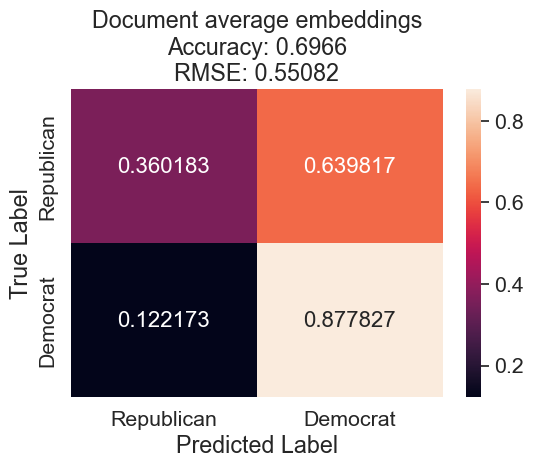

In [26]:
train_model(doc_avg_embeddings, engineered_features['party_Democrat'], "Republican", "Democrat", "Document average embeddings")

### Document Average Embeddings x Position

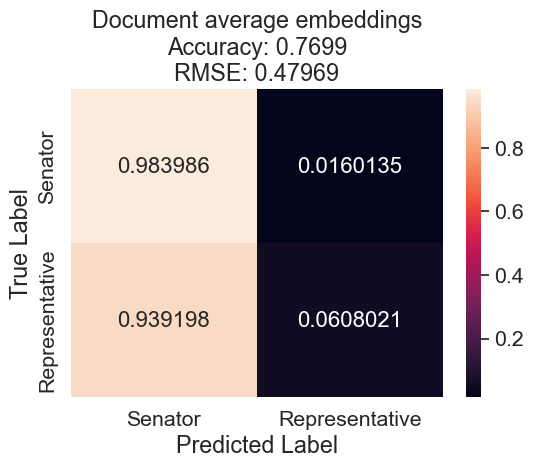

In [27]:
train_model(doc_avg_embeddings, engineered_features['position_Sen'], 
            "Senator", "Representative", "Document average embeddings")

### Engineered features + top 25 n-grams + topic model x Party

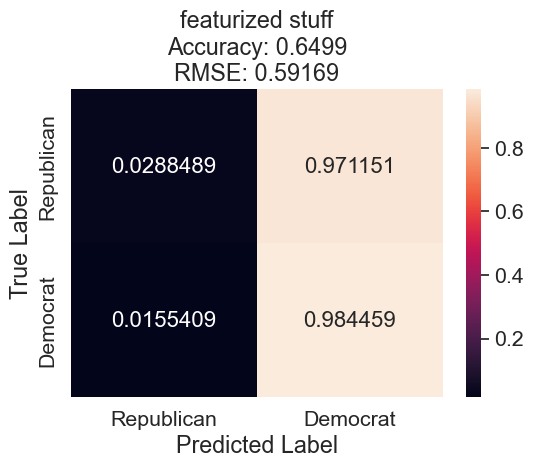

In [28]:
train_model(engineered_features.drop(columns = ["party_Republican", "party_Democrat", "party_Independent", "position_Sen", "position_Rep"]),
            engineered_features['party_Democrat'],
            "Republican", 
            "Democrat", 
            "Engineered features")

### Engineered features + top 25 n-grams + topic model x Position

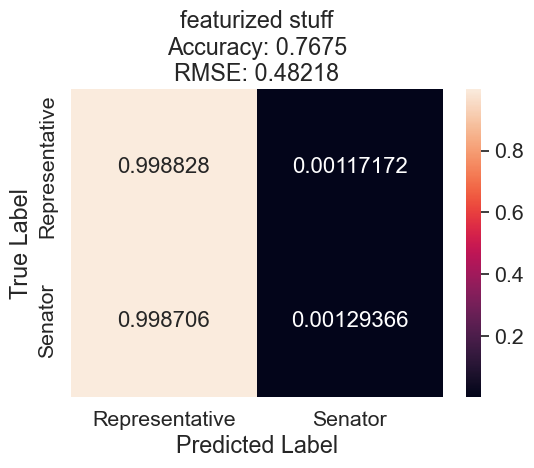

In [29]:
train_model(engineered_features.drop(columns = ["party_Republican", "party_Democrat", "party_Independent", "position_Sen", "position_Rep"]),
            engineered_features['position_Sen'],
            "Representative", 
            "Senator", 
            "Engineered features")

### TF-IDF x Party

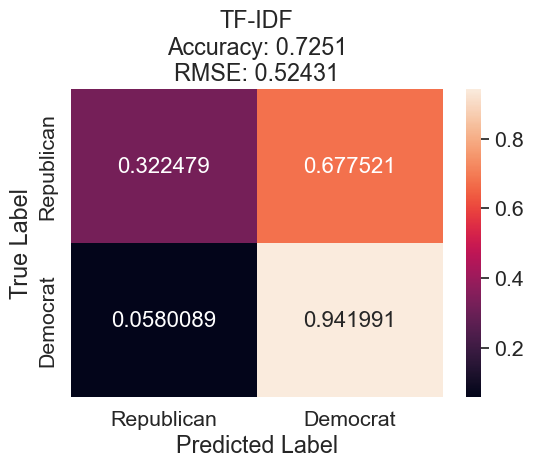

In [30]:
train_model(tfidf_df,
            engineered_features['party_Democrat'],
            "Republican", 
            "Democrat", 
            "TF-IDF")

### Engineered features x Position

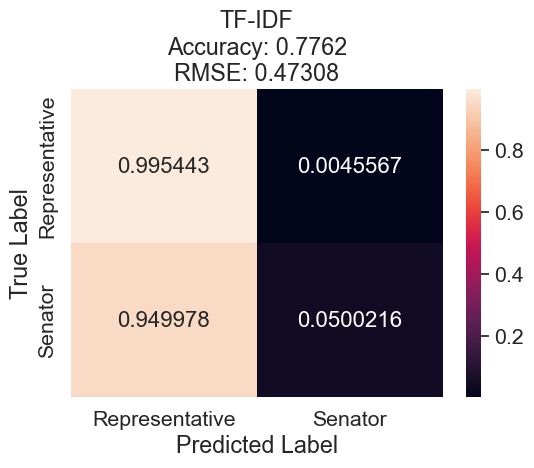

In [31]:
train_model(tfidf_df,
            engineered_features['position_Sen'],
            "Representative", 
            "Senator", 
            "TF-IDF")

### Two Combined Models

In [33]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
nontext_features = congress_tweets[['trump_2016_state_share',
                                     'clinton_2016_state_share', 
                                     'obama_2012_state_share', 
                                     'romney_2012_state_share',
                                     'gender', 'state']]

nontext_features = pd.get_dummies(nontext_features, columns = ["gender", "state"], dtype = int)

# make sure columns are numeric
nontext_features = nontext_features.apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',', ''), errors='coerce'))

# join to engineered features
tfidf_nontext = tfidf_df.join(nontext_features)

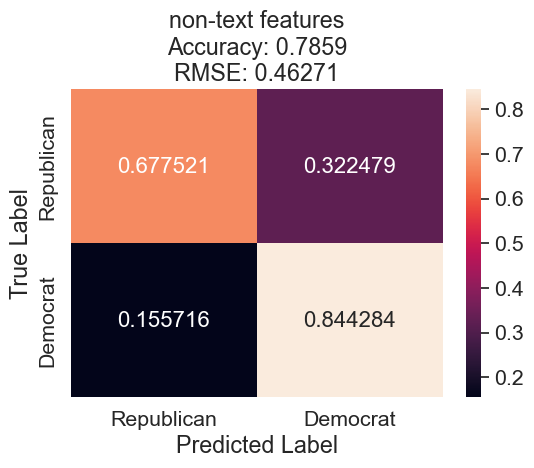

In [34]:
train_model(nontext_features,
            engineered_features['party_Democrat'],
            "Republican", 
            "Democrat", 
            "non-text features")

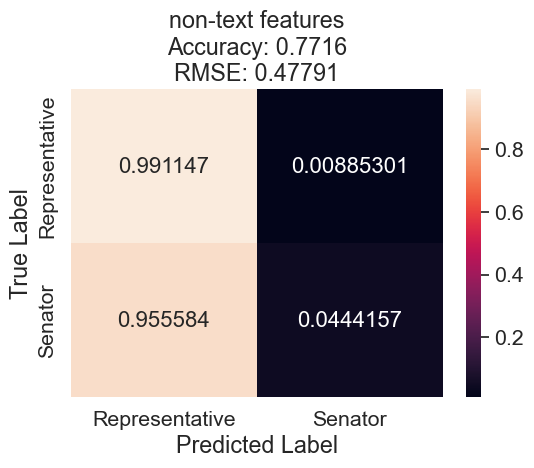

In [35]:
train_model(nontext_features,
            engineered_features['position_Sen'],
            "Representative", 
            "Senator", 
            "non-text features")

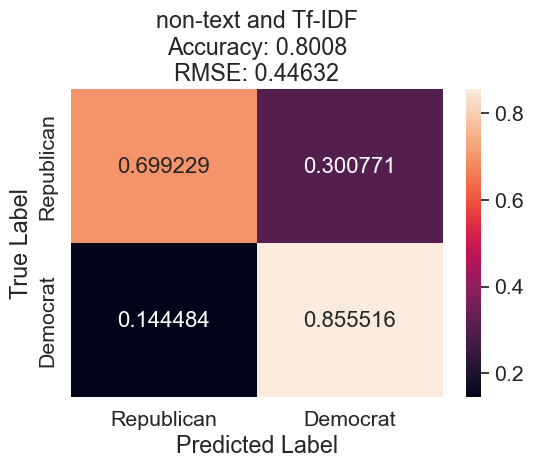

In [37]:
train_model(tfidf_nontext,
            engineered_features['party_Democrat'],
            "Republican", 
            "Democrat", 
            "non-text and TF-IDF")

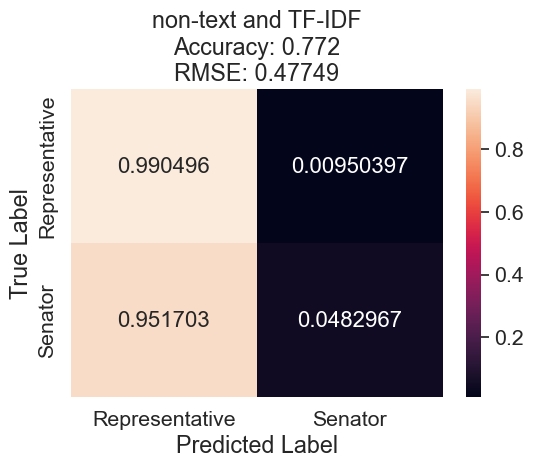

In [39]:
train_model(tfidf_nontext,
            engineered_features['position_Sen'],
            "Representative", 
            "Senator", 
            "non-text and TF-IDF")

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

Standard preprocessing methods need to be customized for a given corpus because vocabulary and jargon could be context dependent, which could alter what stop words to use. Also, the formatting of text varies depending on the type of documents in the corpus.

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

I did not find strong enough evidence of different sentiments when comparing democrats and republicans, nor with senators and representatives. This could definitely be entirely due to how I preprocessed the tweets, though. I'd be curious to see how this would turn out with a cleaner corpus.

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

It is valuable to validate exploratory and unsupervised methods with supervised algorithms in order to add human interpretability in. For example, the "topics" produced using LDA do not have any real meaning behind them (at least not in an obvious way), but using supervised methods can help you see what those topics are actually correlated with.

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

The best performance came from using non-text features in combination with the TF-IDF. It's useful to combine text and non-text features in supervised learning to provide additional context that just one type of feature cannot provides on its own. For example, exploring sentiment can only be done by analyzing the text itself, but information such as voter share cannot really be inferred from text.